## Урок 7. Домашнее задание

1. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике? 

Больше всего из представленных на уроке алгоритмов меня заинтересовала сеть YOLO. Оригинальная работа была представлена еще в 2016 году (https://arxiv.org/pdf/1506.02640.pdf).

Основным преимуществом модели является скорость ее работы. Благодаря оригинальному для того времени подходу с одновременным предсказанием возможных рамок и классов объектов, находящихся внутри этих рамок, эта сеть может обрабатывать изображения/видео в реальном времени, с минимальной задержкой. Другим преимуществом данной модели является то, что она работает  сразу с полным изображением, а значит может построить больше признаков.

Авторы указывают, что базовая модель этого типа обрабатывает 45 кадров в секунду, а облегченная Fast YOLO (которая содержит меньше сверточных слоев) способна  анализировать до 155 кадров в секунду. Кроме того очень важно то, что метрики, которые удается достичь с использованием базового YOLO, на большинстве известных датасетов оказываются сопоставимы с результатами более тяжелых и медленных моделей. Для легкого YOLO они уже ниже и здесь уже более остро встает вопрос выбора между скоростью и качеством.

Модель строит сетку заданного размера $S$ x $S$ поверх каждого изображения, далее для каждого элемента сетки строится заранее определенное количество рамок и рассчитываются вероятностные оценки того, что в этих рамках находится какой-то объект, а также вероятность принадлежности этого объекта к существующим классам. Базовая YOLO состоит из 24 сверточных слоев и 2 полносвязных, легкая YOLO содержит 9 сверточных слоев, кроме того в них меньше ядер, что позволяет ей работать еще быстрее.

В статье также приведено сравнение модели YOLO с Fast R-CNN, которая в то время была одной из ведущих сетей для распознавания объектов. YOLO допускает больше ошибок, связанных с локализацией объектов, зато намного меньше подвержена ложнопозитивным срабатываниям при обнаружении объектов на изображении. YOLO относительно плохо справляется с распознаванием групп маленьких объектов, таких как например стаи птиц.

Авторы также предпринимают попытку объединить две модели: Fast R-CNN и YOLO. Итоговая метрика получившейся сети на датасете PASCAL VOC 2007 значительно лучше показателей каждой из моделей ее составляющих. 

Наконец авторы подчеркивают, что предобученная модель лучше конкурентов генерализует классы и хорошо показывает себя при распознавании объектов на новых изображениях.

Модель YOLO и ее модификации продолжают использоваться до сих пор, что говорит о ее хорошем качестве и применимости для решения задач распознавания объектов. Например, в 2021 году была представлена модель YOLOR (https://arxiv.org/pdf/2105.04206v1.pdf), которая значительно усложняет исходную модель, добавляя в нее элементы неявного обучения (насколько я понял вводятся дополнительные вектора, которые меняются в ходе обучения модели, но при этом не зависят от наблюдений). Благодаря этому сеть показывает очень хорошие результаты, в частности на датасете COCO (https://paperswithcode.com/sota/object-detection-on-coco?tag_filter=15).


2. Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

Воспользуемся кодом и сетями из ноутбука с детекторами, который был показан на уроке.

In [1]:
#Импорт всего

# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
# %tensorflow_version can likely be used after 2.0rc0  
#!pip install tf-nightly-gpu-2.0-preview
#!pip install tf-nightly-gpu-2.0-preview
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow

import tensorflow as tf

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline

import cv2 as cv


# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


In [2]:
# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Загрузка детектора:

In [3]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


 Формируем тензор из картинки:

In [4]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

Функция, отвечающая за работу детектора:

In [5]:

def run_detector(detector, path, max_boxes=10):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_boxes)

  display_image(image_with_boxes)
  return result

Возвращаем рамки для объектов:

In [6]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [7]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

Посмотрим на результаты сначала для 10 объектов:

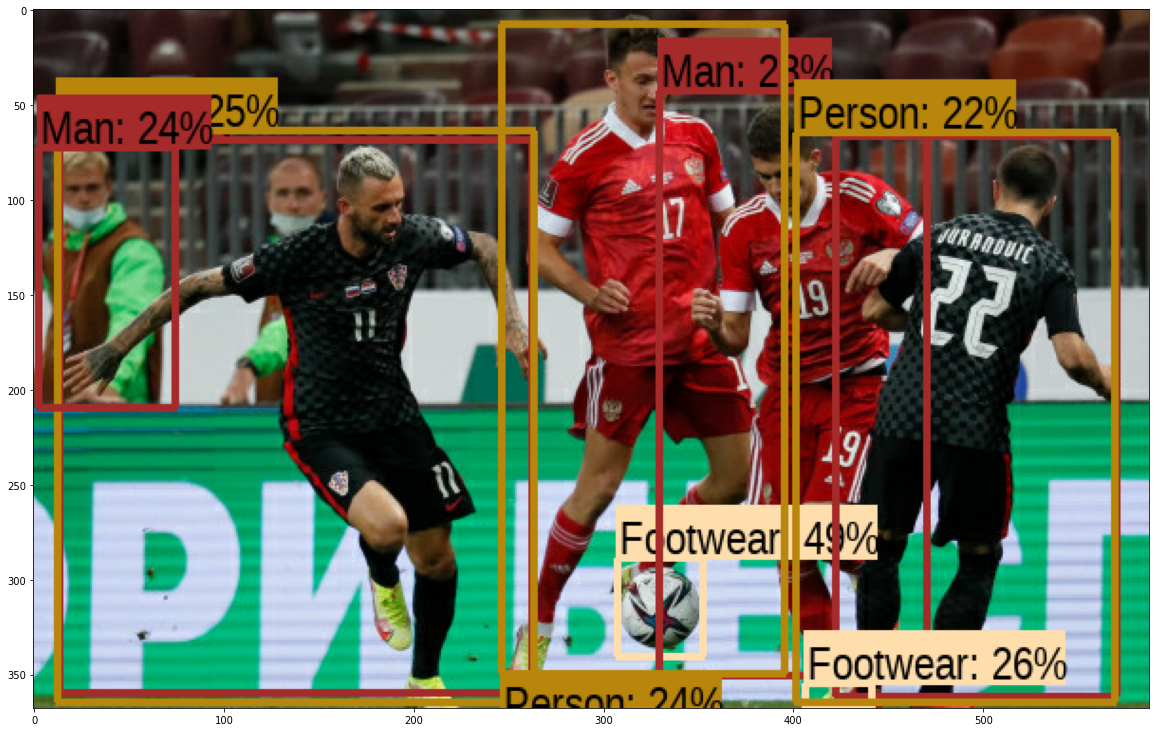

In [9]:
result = run_detector(detector, np.array('image.jpg'))


Выведем результаты работы детектора в виде коэффициентов:

In [ ]:
result